# Evaluation

In [11]:
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from datasets import load_dataset, Dataset
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import numpy as np
from transformers import Wav2Vec2ForCTC, TrainingArguments, Trainer
import evaluate
import os
import random
import pandas as pd
from IPython.core.display import HTML

In [12]:
BASE_PATH = "."
FIGURE_PATH = os.path.join(BASE_PATH, "figures")
RUNS_PATH = os.path.join(BASE_PATH, "runs")
DATASETS_PATH = os.path.join(BASE_PATH, "datasets")
SAMPLING_RATE = 200 * 10**6
datasetPath = lambda name: os.path.join(DATASETS_PATH, name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
def load_model(model_path):

    processor = Wav2Vec2Processor.from_pretrained(model_path)
    model = Wav2Vec2ForCTC.from_pretrained(model_path).to(device)
    model.eval()

    return model, processor

In [14]:
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [15]:
def expand_dataset_with_repetitions(dataset, processor, shuffle=True):
    """
    Expand each matrix entry into N separate dataset entries, each with the same labels
    """
    expanded_data = {
        "input_values": [],
        "input_length": [],
        "labels": [],
        "program_label": []  # Keep original text labels for reference
    }
    
    for example in dataset:
        # Load numpy trace data
        traces = np.load(example["traces"])

        # Handle both single traces and matrices
        if traces.ndim == 1:
            # Single trace - keep as one entry
            traces = [traces]
        else:
            # Matrix - each row becomes a separate entry
            traces = [traces[j] for j in range(traces.shape[0])]
        
        # Process labels once for this example
        processed_labels = processor(text=example["program_label"]).input_ids
        
        # Create separate dataset entries for each trace repetition
        for trace in traces:
            # Process the trace
            processed_trace = processor(trace, sampling_rate=SAMPLING_RATE).input_values[0]
            
            # Add to expanded dataset
            expanded_data["input_values"].append(processed_trace)
            expanded_data["input_length"].append(len(processed_trace))
            expanded_data["labels"].append(processed_labels)
            expanded_data["program_label"].append(example["program_label"])
        
    if shuffle:
        # Convert to list of indices and shuffle
        indices = list(range(len(expanded_data["input_values"])))
        random.shuffle(indices)
        
        # Reorder all lists according to shuffled indices
        for key in expanded_data:
            expanded_data[key] = [expanded_data[key][i] for i in indices]
    
    return expanded_data

def prepare_data(dataset_path, processor):
    from datasets import DatasetDict
    # Set up data
    splits = ["train", "val", "test"]
    data_paths = [os.path.join(dataset_path, f"{split}.json") for split in splits]
    data_files = {split: path for split, path in zip(splits, data_paths)}
    data = load_dataset("json", data_files=data_files, field="batches")

    print("Expanding datasets with repetitions...")

    # Expand each split
    expanded_datasets = {}
    for split in splits:
        if split in data:
            print(f"Expanding {split} split...")
            expanded_data = expand_dataset_with_repetitions(data[split], processor)
            expanded_datasets[split] = Dataset.from_dict(expanded_data)
            print(f"  {split}: {len(data[split])} -> {len(expanded_datasets[split])} examples")

    # Create the final dataset
    return DatasetDict(expanded_datasets)

In [16]:
# Load the WER metric
def compute_metrics(pred, processor):
    import evaluate

    # Load the WER metric
    wer_metric = evaluate.load("wer")

    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Create a copy to avoid modifying original
    label_ids = pred.label_ids.copy()
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, spaces_between_special_tokens=True)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(label_ids, group_tokens=False, spaces_between_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In [17]:
def word_substitution_matrix(results, name=None):
    import jiwer
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import os

    measures = jiwer.compute_measures(results["text"], results["pred_str"])

    substitutions = []
    correct_words = []
    
    for i in range(len(results["text"])):
        ops = measures["ops"][i]
        ref = results["text"][i].split(" ")
        hyp = results["pred_str"][i].split(" ")
        
        # Track which positions have operations applied
        ref_operated = set()
        hyp_operated = set()
        
        for op in ops:
            if op.type == "substitute":
                ref_range = range(op.ref_start_idx, op.ref_end_idx)
                hyp_range = range(op.hyp_start_idx, op.hyp_end_idx)
                
                # Mark positions as operated on
                ref_operated.update(ref_range)
                hyp_operated.update(hyp_range)
                
                # If this isn't the case, substitution is imbalanced.
                assert len(ref_range) == len(hyp_range)

                for r, h in zip(ref_range, hyp_range):
                    substitutions.append((ref[r], hyp[h]))
            else:
                # For insertions and deletions, mark the positions
                if op.type == "insert":
                    hyp_operated.update(range(op.hyp_start_idx, op.hyp_end_idx))
                elif op.type == "delete":
                    ref_operated.update(range(op.ref_start_idx, op.ref_end_idx))
        
        # Find correct words (positions not involved in any operation)
        # We need to align ref and hyp positions accounting for insertions/deletions
        min_len = min(len(ref), len(hyp))
        for pos in range(min_len):
            if pos not in ref_operated and pos not in hyp_operated:
                if pos < len(ref) and pos < len(hyp):
                    correct_words.append(ref[pos])

    substitutions = Counter(substitutions)
    correct_words = Counter(correct_words)

    # Get all unique words from both substitutions and correct words
    all_words = set()
    for ref_word, hyp_word in substitutions.keys():
        all_words.add(ref_word)
        all_words.add(hyp_word)
    all_words.update(correct_words.keys())

    words = sorted(all_words)

    # Create confusion matrix
    confusion_matrix = pd.DataFrame(0, index=words, columns=words)

    # Add substitutions (off-diagonal elements)
    for (ref_word, hyp_word), count in substitutions.items():
        confusion_matrix.loc[ref_word, hyp_word] = count
    
    # Add correct classifications (diagonal elements)
    for word, count in correct_words.items():
        confusion_matrix.loc[word, word] += count

    # Create figure
    plt.figure(figsize=(max(8, len(words) * 0.5), max(6, len(words) * 0.4)))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Word Count'})
    
    if name:
        title_prefix = " ".join(name.split("-")).title() + " - "
    else:
        title_prefix = ""
    
    title = f'{title_prefix}Word Confusion Matrix'
    plt.title(title)
    plt.xlabel('Hypothesis Words (Predicted)')
    plt.ylabel('Reference Words (True)')
    plt.tight_layout()
    
    filename = title.replace(" ", "_") + ".png"
    plt.savefig(os.path.join(FIGURE_PATH, filename))
    plt.show()
    
    return confusion_matrix

In [18]:
def antagonist_mcnemar(results):
    from statsmodels.stats.contingency_tables import mcnemar
    from collections import defaultdict
    import jiwer

    # Naive hypothesis set up

    word_dict = defaultdict(lambda: 0)

    for text in results["text"]:
        words = text.split(" ")
        for word in words:
            word_dict[word] += 1

    # Get the most common word and its count
    most_common_word = max(word_dict, key=word_dict.get)
    most_common_count = word_dict[most_common_word]
    print(f"Most common word: '{most_common_word}' with count: {most_common_count}")

    # Conservative McNemar Metrics
    measures = jiwer.compute_measures(results["text"], results["pred_str"])

    both_correct = 0
    your_correct_naive_wrong = 0
    your_wrong_naive_correct = 0
    both_wrong = 0

    for ref, hyp, ops in zip(results["text"], results["pred_str"], measures["ops"]):
        ref_words = ref.split(" ")
        hyp_words = hyp.split(" ")

        for op in ops:
            if op.type == 'equal':
                # Hypothesis: correct
                # Check null
                idx_range = range(op.ref_start_idx, op.ref_end_idx)
                for i in idx_range:
                    ref_word = ref_words[i]
                    naive_correct = (most_common_word == ref_word)
                    
                    if naive_correct:
                        both_correct += 1
                    else:
                        your_correct_naive_wrong += 1
                    
            elif op.type == 'substitute':
                # Hypothesis: incorrect  
                # Check null
                idx_range = range(op.ref_start_idx, op.ref_end_idx)
                for i in idx_range:
                    ref_word = ref_words[i]
                    naive_correct = (most_common_word == ref_word)
                    
                    if naive_correct:
                        your_wrong_naive_correct += 1
                    else:
                        both_wrong += 1
                    
            elif op.type == 'delete':
                # Hypothesis: incorrect (missed the word)
                # Check null
                idx_range = range(op.ref_start_idx, op.ref_end_idx)
                for i in idx_range:
                    ref_word = ref_words[i]
                    naive_correct = (most_common_word == ref_word)
                    
                    if naive_correct:
                        your_wrong_naive_correct += 1
                    else:
                        both_wrong += 1
                    
            elif op.type == 'insert':
                # Penalty: the model made extra prediction
                # This doesn't correspond to any reference word, so we penalize
                # as much as possible by defaulting the naive model to be correct, and
                # our model to be wrong.
                idx_range = range(op.hyp_start_idx, op.hyp_end_idx)
                for i in idx_range:
                    your_wrong_naive_correct += 1 # maximum punishment

    table = [[both_correct, your_correct_naive_wrong],
                [your_wrong_naive_correct, both_wrong]]

    # Create the data matrix
    data = np.array(table)

    col_index = pd.MultiIndex.from_tuples([
        ('H₀ (Naive Model)', 'Correct'),
        ('H₀ (Naive Model)', 'Incorrect')
    ])

    row_index = pd.MultiIndex.from_tuples([
        ('H (Our Model)', 'Correct'),
        ('H (Our Model)', 'Incorrect')
    ])

    # Create DataFrame
    df = pd.DataFrame(data, index=row_index, columns=col_index)

    mcnemar_result = mcnemar(table, exact=False, correction=True)
    print(f"\nAntagonistic McNemar's Test Results:")
    display(df)
    print(f"Chi-square statistic: {mcnemar_result.statistic:.3f}")
    print(f"P-value: {mcnemar_result.pvalue:.3e}")

In [19]:
def evaluate_model(model_path, dataset_path):
    import jiwer

    model, processor = load_model(model_path)

    def map_to_result(batch):
        with torch.no_grad():
            input_values = torch.tensor(batch["input_values"], device=device).unsqueeze(0)
            logits = model(input_values).logits

        pred_ids = torch.argmax(logits, dim=-1)
        batch["pred_str"] = processor.batch_decode(pred_ids, spaces_between_special_tokens=True)[0]
        batch["text"] = processor.decode(batch["labels"], group_tokens=False, spaces_between_special_tokens=True)
        
        return batch

    dataset = prepare_data(dataset_path, processor)

    for split in ["train", "val", "test"]: # Test last, used for analysis
        results = dataset[split].map(map_to_result, remove_columns=dataset[split].column_names)
        measures = jiwer.compute_measures(results["text"], results["pred_str"])
        print(f"{split} WER: ", measures["wer"], "W_acc: ",  1-measures["wer"])    

    show_random_elements(results)

    num_correct = 0
    for i in range(len(results["pred_str"])):
        pred1 = results["pred_str"][i].split(" ")[0]
        text1 = results["text"][i].split(" ")[0]
        if pred1 == text1:
            num_correct += 1
    firstWordAcc = num_correct / len(results)

    print(f"Accuracy of the first predicted token: {firstWordAcc}")

    word_substitution_matrix(results, name=model_path.split("/")[-1])

    antagonist_mcnemar(results)

    return results

## Final Results

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Expanding datasets with repetitions...
Expanding train split...
  train: 1119 -> 5595 examples
Expanding val split...
  val: 241 -> 1205 examples
Expanding test split...
  test: 240 -> 1200 examples


Map:   0%|          | 0/5595 [00:00<?, ? examples/s]

train WER:  0.10886199492484872 W_acc:  0.8911380050751513


Map:   0%|          | 0/1205 [00:00<?, ? examples/s]

val WER:  0.24587912087912087 W_acc:  0.7541208791208791


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

test WER:  0.23392029657089897 W_acc:  0.766079703429101


,pred_str,text
0,bgeu bgeu bgeu sh bgeu jal srl bgeu,bgeu bgeu bgeu sh bgeu jal srl bgeu
1,srl jal bgeu addi sh bgeu sh bgeu jal,srl jal bgeu addi bgeu sh bgeu jal
2,srl jal bgeu addi sh srl addi bgeu srl sh jal,srl jal addi addi sh srl addi bgeu srl sh jal
3,sh srl sh jal addi bgeu jal,sh srl sh jal bgeu bgeu jal
4,jal jal srl addi jal sh bgeu jal sh srl srl bgeu,jal jal srl addi jal sh bgeu jal sh bgeu srl bgeu


Accuracy of the first predicted token: 0.8383333333333334


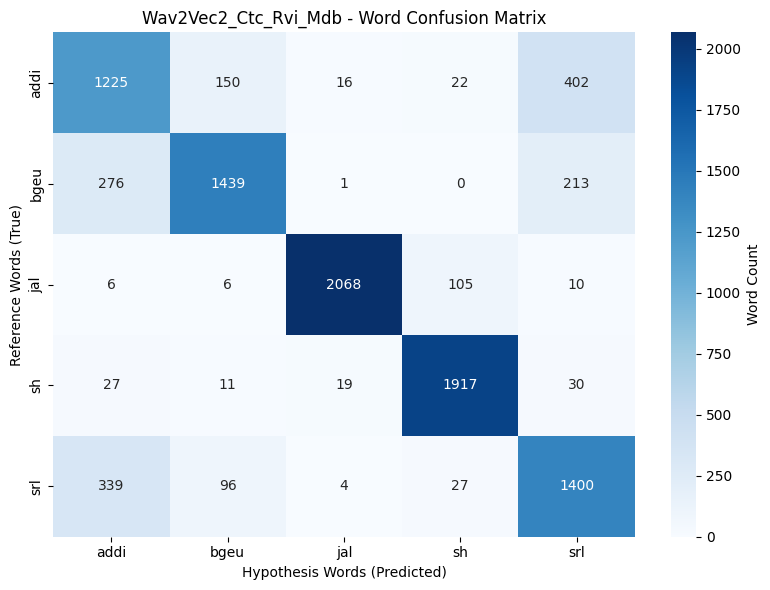

Most common word: 'jal' with count: 2305

Antagonistic McNemar's Test Results:


H₀ (Naive Model)          
                                 Correct Incorrect
H (Our Model) Correct               2153      6423
              Incorrect              462      2062

Chi-square statistic: 5159.274
P-value: 0.000e+00


Dataset({
    features: ['pred_str', 'text'],
    num_rows: 1200
})

In [20]:
evaluate_model("./runs/wav2vec2_ctc_rvi_mdb", "./datasets/full_rvi_mdb")